# PySpark-Jupyter Notebook Mac Setup  
-Source: https://medium.com/@GalarnykMichael/install-spark-on-mac-pyspark-453f395f240b  

1. Download Anaconda (choose verion for your desired python distribution): https://www.anaconda.com/distribution/  
> - Follow installation steps  
> - Do NOT install pyspark package, this will cause source conflict issues  

2. Download Java8, the latest version of Java supported by Spark  
> - With Homebrew: type <b>brew cask install adoptopenjdk/openjdk/adoptopenjdk8</b> in terminal    
> - If another version of Java is installed, be sure to set you JAVA_HOME environment variable in the terminal or your bash_profile:  
<b>export JAVA_HOME=/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home</b>  
> - Alternatively you can set the Java version using: <b>export JAVA_HOME=$(/usr/libexec/java_home -v 1.8)</b>  

3. Download Apache Spark binaries: http://spark.apache.org/downloads.html  
> - Unzip and move to your home folder (you can navigate there by typing <b>cd ~'</b> in the terminal)  
> - While in your home directory type <b>nano .bash_profile</b> and add the following lines:  
<b>export SPARK_PATH=~/[YOUR_SPARK_VERSION_FOLDER]  
export PYSPARK_DRIVER_PYTHON="jupyter"  
export PYSPARK_DRIVER_PYTHON_OPTS="notebook"  
alias snotebook='$SPARK_PATH/bin/pyspark --master local[2]'</b>  
> - To finalize changes type <b>source .bash_profile</b>  
> - Note: you can replace "snotebook" with whatever command you want to use to activate a Spark notebook  

4. Now open a terminal and simply type <b>snotebook</b> to get started in Spark with Jupyter notebook!    
  
5. You may see an error about loading native Hadoop library, this will not affect functionality but if you want to fix this:  
> - Download your chosen Hadoop version BINARY from Apache: http://hadoop.apache.org/  
> - Unzip and move to your home directory  
> - Add the following to your bash_profile: <b>export HADOOP_HOME=~/hadoop-2.8.0</b> with your corresponding version name  
> - Restart the terminal and the warning should be gone!  

In [1]:
from pyspark.sql.functions import when, lit, col, unix_timestamp, dayofyear, hour, minute, dayofmonth
from pyspark.sql.functions import isnull,date_trunc, window, countDistinct, desc, to_utc_timestamp, from_unixtime
from pyspark.sql.types import DateType, TimestampType, LongType, IntegerType, DoubleType, FloatType
from pyspark.sql import DataFrame, Row
from pyspark.sql.window import Window
import pyspark.sql.functions as func
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import HashingTF, Tokenizer, IndexToString, StringIndexer,\
VectorIndexer, VectorAssembler, StandardScaler, CountVectorizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from sklearn.model_selection import train_test_split
import time

import keras
from keras.layers import LSTM, RepeatVector, TimeDistributed
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import RMSprop
from keras import optimizers

from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperopt import Trials, STATUS_OK, tpe

Using TensorFlow backend.


In [2]:
spark

In [3]:
sc

<SparkContext master=local[2] appName=PySparkShell>

# Exploratory Data Analysis (EDA)  
The dataset used in this notebook is CICIDS2017 from University of New Brunswick, which contains attacks on real-world network data. The dataset can be downloaded here: https://www.unb.ca/cic/datasets/ids-2017.html. The breakdown of the data is as follows:  
  
Monday has no attacks, only normal network flow  
Tuesday-Friday all have different attacks associated with certain timestamps    
  
<b>Note:</b> This is not a full EDA, and in real-world scenarios you should spend much more time understanding the dataset you are working with. This cheatsheet helped immensely in my Spark ramp-up as well: https://s3.amazonaws.com/assets.datacamp.com/blog_assets/PySpark_SQL_Cheat_Sheet_Python.pdf

In [4]:
#https://www.unb.ca/cic/datasets/ids-2017.html

#Change the url to match folder location for the data
df1 = spark.read.csv('UNB_IDSdata/MachineLearningCVE/Tuesday-WorkingHours.pcap_ISCX.csv',sep=',',header=True)
df1.show(5)

+-----------------+--------------+------------------+-----------------------+---------------------------+----------------------------+----------------------+----------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+----------------------+------------+---------------+--------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+-------------+-------------+------------+------------+------------+-------------+--------------+--------------+--------------+--------------------+------------------+-------------+--------------+------------------+------------------+-------------------+------------------+-----------------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------------+---------------------+---------------------+--------------------+----

In [5]:
#Currently all data is stored as strings, a first step would be to cast relevant columns to integer/float
print(df1.dtypes[1])


#Cast all columns to float, EXCEPT leave label as string for now (deal with it later)
#Destination Port is also left as a string, which will be explained later
df1 = df1.select(*(col(c).cast("float").alias(c) if (c!=' Label' and c!=' Destination Port') else col(c) for c in df1.columns))
print("\n\n",df1.dtypes[1])

(' Flow Duration', 'string')


 (' Flow Duration', 'float')


In [6]:
df1.dtypes

[(' Destination Port', 'string'),
 (' Flow Duration', 'float'),
 (' Total Fwd Packets', 'float'),
 (' Total Backward Packets', 'float'),
 ('Total Length of Fwd Packets', 'float'),
 (' Total Length of Bwd Packets', 'float'),
 (' Fwd Packet Length Max', 'float'),
 (' Fwd Packet Length Min', 'float'),
 (' Fwd Packet Length Mean', 'float'),
 (' Fwd Packet Length Std', 'float'),
 ('Bwd Packet Length Max', 'float'),
 (' Bwd Packet Length Min', 'float'),
 (' Bwd Packet Length Mean', 'float'),
 (' Bwd Packet Length Std', 'float'),
 ('Flow Bytes/s', 'float'),
 (' Flow Packets/s', 'float'),
 (' Flow IAT Mean', 'float'),
 (' Flow IAT Std', 'float'),
 (' Flow IAT Max', 'float'),
 (' Flow IAT Min', 'float'),
 ('Fwd IAT Total', 'float'),
 (' Fwd IAT Mean', 'float'),
 (' Fwd IAT Std', 'float'),
 (' Fwd IAT Max', 'float'),
 (' Fwd IAT Min', 'float'),
 ('Bwd IAT Total', 'float'),
 (' Bwd IAT Mean', 'float'),
 (' Bwd IAT Std', 'float'),
 (' Bwd IAT Max', 'float'),
 (' Bwd IAT Min', 'float'),
 ('Fwd PSH 

As you can see, there are a bunch of columns, making it difficult to visualize the data especially in Spark. A subset of columns can be taken to show some of the data exploration functionality in Spark. The 'decribe' method prints statistics associated with each column (however, this dataset actually includes some of these statistics as extra columns by default).

In [7]:
#Selects two columns, determines statistical measures, and prints
df1.select(' Subflow Bwd Bytes','Total Length of Fwd Packets').describe().show() 

+-------+------------------+---------------------------+
|summary| Subflow Bwd Bytes|Total Length of Fwd Packets|
+-------+------------------+---------------------------+
|  count|            445909|                     445909|
|   mean| 21861.62704273742|          530.2105429583166|
| stddev| 2625473.325022229|          5676.904047554064|
|    min|               0.0|                        0.0|
|    max|       6.2703904E8|                  2428415.0|
+-------+------------------+---------------------------+



The dataset contains mostly continuous columns and only have a few Categorical columns:  

    Destination Port  
    Fwd PSH Flags, Bwd PSH Flags, Fwd URG Flags, Bwd URG Flags  
    label (our truth label for the data)  
    
label needs to be dealt with separately, but we still need to somehow prepare our other categorical columns to decide how we should handle them.

In [8]:
#Select the categorical columns, then find the cardinality of each and popular values
categories = df1.select(' Destination Port', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', " Label")

#This call will give counts of Destination ports ordered highest to lowest
port_counts = categories.groupby(' Destination Port').agg(func.count('Fwd PSH Flags').alias('dstport_occurences'))\
.sort(col('dstport_occurences').desc())

print("Number of unique ports: ",port_counts.count())
port_counts.show()

Number of unique ports:  31858
+-----------------+------------------+
| Destination Port|dstport_occurences|
+-----------------+------------------+
|               53|            190939|
|              443|             97276|
|               80|             45676|
|               21|              8996|
|               22|              8033|
|              123|              5145|
|              137|              1911|
|              389|              1333|
|               88|              1232|
|              465|               710|
|             3268|               607|
|              139|               564|
|              445|               372|
|              138|               318|
|                0|               316|
|              135|               178|
|            49666|               172|
|             5353|               148|
|             5355|               102|
|            49671|                69|
+-----------------+------------------+
only showing top 20 rows



In [9]:
categ_cols = [' Destination Port', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', " Label"]

In [10]:
#To speed up experimentation, the following code will loop through each categorical column and print its cardinality
#and top values:
for c in categ_cols:
    counts = categories.groupby(c).agg(func.count(' Destination Port').alias(c+'_occurences'))\
    .sort(col(c+'_occurences').desc())

    print("Number of unique "+c+": ",counts.count())
    counts.show()

Number of unique  Destination Port:  31858
+-----------------+----------------------------+
| Destination Port| Destination Port_occurences|
+-----------------+----------------------------+
|               53|                      190939|
|              443|                       97276|
|               80|                       45676|
|               21|                        8996|
|               22|                        8033|
|              123|                        5145|
|              137|                        1911|
|              389|                        1333|
|               88|                        1232|
|              465|                         710|
|             3268|                         607|
|              139|                         564|
|              445|                         372|
|              138|                         318|
|                0|                         316|
|              135|                         178|
|            49666|       

In [11]:
##Example visualizations in pandas:
ports = categories.groupby(' Destination Port').agg(func.count(' Destination Port').alias(' Destination Port_occurences'))\
    .sort(col(' Destination Port_occurences').desc())

labels = categories.groupby(' Label').agg(func.count(' Label').alias(' Label_occurences'))\
    .sort(col(' Label_occurences').desc())


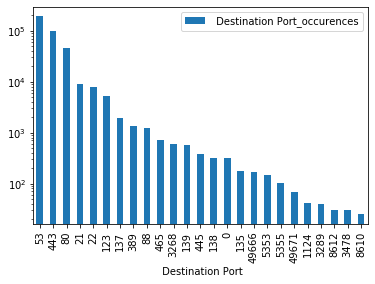

In [12]:
pdports = ports.limit(25).toPandas()
pdports.plot.bar(' Destination Port', ' Destination Port_occurences',logy=True)

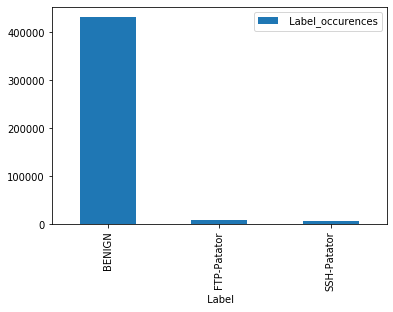

In [13]:
pdlabels = labels.toPandas()
pdlabels.plot.bar(' Label', ' Label_occurences')

Based on the above distributions, one should likely discard BWD PSH and both "URG" features, as they provide no distinguishing information about the records.

# Feature Engineering & Data Cleaning

## Categorical Variables

According to the above analysis, the Flags variables seem to have binary values, with Ports being the only categorical column with very high cardinality. We will likely have to create a new feature for ports, since one-hot encoding would create too many new columns. 
  
In this case, we can use the number of times each port shows up in normal traffic to create "usage bins" for ports, such that bins with similar number of occurences are seen as similar to the algorithm. There should also be a bin for ports that have not been seen before to avoid erroring upon seeing new port behavior. To do this, we will use the <b>Bucketizer</b> class from PySpark.

In [14]:
from pyspark.ml.feature import Bucketizer

#This defines the split values for our buckets, these can be adjusted, and are based
#roughly on the counts from above
splits = [0, 1, 50, 100, 1000, 5000, 10000, 100000, float('Inf')]

bucketizer = Bucketizer(splits=splits, inputCol="dstport_occurences",\
                        outputCol="bucketedPorts")

# Transform original data into its bucket index.
bucketedData = bucketizer.setHandleInvalid("keep").transform(port_counts)

##Essentially, this creates a mapping from port number -> its usage bucket below,
##This will be used on incoming data to assign ports to buckets
print("Bucketizer output with %d buckets" % (len(bucketizer.getSplits())-1))
bucketedData.show()

Bucketizer output with 8 buckets
+-----------------+------------------+-------------+
| Destination Port|dstport_occurences|bucketedPorts|
+-----------------+------------------+-------------+
|               53|            190939|          7.0|
|              443|             97276|          6.0|
|               80|             45676|          6.0|
|               21|              8996|          5.0|
|               22|              8033|          5.0|
|              123|              5145|          5.0|
|              137|              1911|          4.0|
|              389|              1333|          4.0|
|               88|              1232|          4.0|
|              465|               710|          3.0|
|             3268|               607|          3.0|
|              139|               564|          3.0|
|              445|               372|          3.0|
|              138|               318|          3.0|
|                0|               316|          3.0|
|            

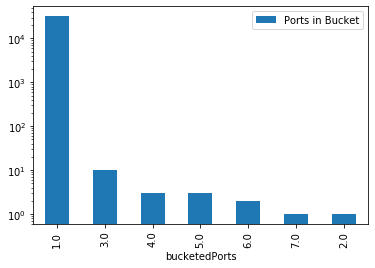

In [15]:
bucketspd = bucketedData.groupby('bucketedPorts').agg(func.count(' Destination Port').alias('Ports in Bucket'))\
    .sort(col('Ports in Bucket').desc()).limit(50).toPandas()
bucketspd.plot.bar('bucketedPorts', 'Ports in Bucket', logy=True)

In [16]:
##This step is to avoid naming issues in the following join
bucketedData = bucketedData.withColumn("dstport", col(" Destination Port"))
#bucketedData.show(truncate=False)

In [17]:
####join tables: df1 and bucketedData to get bucketedPorts in df1
df = df1.join(bucketedData.select("dstport", "bucketedPorts"), df1[" Destination Port"]==bucketedData['dstport'])

##Sanity Check
#df4.groupBy('bucketedPorts').count().orderBy('count').show()


#Drop the categorical values and keep only buckets
df = df.drop(" Destination Port", "dstport")
df = df.withColumn("bucketedPorts", col("bucketedPorts").cast("float"))

df.show(10)

+--------------+------------------+-----------------------+---------------------------+----------------------------+----------------------+----------------------+-----------------------+----------------------+---------------------+----------------------+-----------------------+----------------------+------------+---------------+--------------+-------------+-------------+-------------+-------------+-------------+------------+------------+------------+-------------+-------------+------------+------------+------------+-------------+--------------+--------------+--------------+--------------------+------------------+-------------+--------------+------------------+------------------+-------------------+------------------+-----------------------+--------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+--------------+--------------------+---------------------+---------------------+--------------------+------------------+---

## Continuous Variables

Meanwhile, the plethora of continuous variables also need to be prepared. Essentially, we can first check if any of them are too highly correlated. Next, we would want to vectorize using PySpark's <b> VectorAssembler</b> and scale them with <b>StandardScaler</b>.

In [18]:
categ_cols = ['bucketedPorts', 'Fwd PSH Flags']

In [19]:
##remember that "cols" holds our categorical columns from above, add labels to it as well and then filter such that
##only the continuous columns are vectorized at this time
cont_cols = list((set(df.columns) - set(categ_cols)) - set([" Label"]))


#Running this locally actually consumed all RAM, on a cluster this likely will not happen,
#but one workaround is to manually chunk operations
cont_cols1 = cont_cols[20:30]
#cont_cols2 = cont_cols[int(round((len(cont_cols)/3))):int(round(2*(len(cont_cols)/3)))]
#cont_cols3 = cont_cols[int(round(2*(len(cont_cols)/3))):]

print(len(cont_cols1))
print(cont_cols)

10
[' Fwd Avg Bulk Rate', ' Bwd Avg Packets/Bulk', ' Fwd URG Flags', ' Active Std', ' Max Packet Length', ' ECE Flag Count', ' Flow IAT Max', ' Flow Packets/s', ' min_seg_size_forward', ' Subflow Bwd Bytes', ' Fwd IAT Min', ' Bwd URG Flags', 'Fwd Packets/s', 'FIN Flag Count', 'Total Length of Fwd Packets', ' Flow Duration', ' Fwd IAT Mean', ' URG Flag Count', 'Bwd IAT Total', ' Packet Length Std', ' Min Packet Length', ' Idle Max', ' Bwd Avg Bytes/Bulk', ' Avg Bwd Segment Size', ' act_data_pkt_fwd', ' Fwd Packet Length Min', 'Flow Bytes/s', ' Total Fwd Packets', ' Packet Length Variance', ' ACK Flag Count', ' Fwd IAT Max', ' Total Length of Bwd Packets', ' Bwd Header Length', ' Fwd Packet Length Max', ' Bwd IAT Std', 'Bwd Packet Length Max', ' Fwd Packet Length Std', ' Bwd IAT Max', 'Bwd Avg Bulk Rate', ' Flow IAT Std', ' Subflow Bwd Packets', ' RST Flag Count', ' Flow IAT Mean', ' Fwd Avg Packets/Bulk', ' Bwd Packet Length Mean', ' Active Max', ' Fwd IAT Std', 'Subflow Fwd Packets', '

In [20]:
#This gathers all continuous variables to one vector column named "features", on which can use StandardScaler or 
#any other scaling/normalization function on this column


assembler = VectorAssembler(
    inputCols=cont_cols1,
    outputCol="features",
    handleInvalid='skip')
vectorizedDF = assembler.transform(df)

Below plots the correlation matrix for the first 10 variables. Unfortunately, local RAM limitations did not allow for printing the full correlation matrix, but it is a good approach to filter extraneous columns like this. PCA is another approach available in PySpark natively, check this link to learn more: https://spark.apache.org/docs/2.2.0/ml-features.html#pca. However in some applications, PCA ruins the context of the data, even if achieving better accuracy it is hard to explain why.

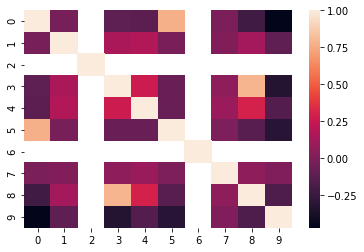

In [21]:
#we want to examine the correlations of these variables, to avoid highly correlated variables which can
#increase bias in the model
from pyspark.ml.stat import Correlation
df_vector = vectorizedDF.select("features")
corr_matrix = Correlation.corr(df_vector, "features")

pd_corr = corr_matrix.collect()[0]["pearson({})".format("features")].toArray().tolist()
pd_corr = pd.DataFrame(pd_corr)
sb.heatmap(pd_corr)

For training, choose a few continuous columns to keep which could be important, please note this is not the best method, but some domain knowledge never hurt either! You can read more about each feature here: http://www.netflowmeter.ca/netflowmeter.html

In [22]:
print(cont_cols)

[' Fwd Avg Bulk Rate', ' Bwd Avg Packets/Bulk', ' Fwd URG Flags', ' Active Std', ' Max Packet Length', ' ECE Flag Count', ' Flow IAT Max', ' Flow Packets/s', ' min_seg_size_forward', ' Subflow Bwd Bytes', ' Fwd IAT Min', ' Bwd URG Flags', 'Fwd Packets/s', 'FIN Flag Count', 'Total Length of Fwd Packets', ' Flow Duration', ' Fwd IAT Mean', ' URG Flag Count', 'Bwd IAT Total', ' Packet Length Std', ' Min Packet Length', ' Idle Max', ' Bwd Avg Bytes/Bulk', ' Avg Bwd Segment Size', ' act_data_pkt_fwd', ' Fwd Packet Length Min', 'Flow Bytes/s', ' Total Fwd Packets', ' Packet Length Variance', ' ACK Flag Count', ' Fwd IAT Max', ' Total Length of Bwd Packets', ' Bwd Header Length', ' Fwd Packet Length Max', ' Bwd IAT Std', 'Bwd Packet Length Max', ' Fwd Packet Length Std', ' Bwd IAT Max', 'Bwd Avg Bulk Rate', ' Flow IAT Std', ' Subflow Bwd Packets', ' RST Flag Count', ' Flow IAT Mean', ' Fwd Avg Packets/Bulk', ' Bwd Packet Length Mean', ' Active Max', ' Fwd IAT Std', 'Subflow Fwd Packets', ' Bw

In [23]:
chosen_cols = ['Fwd Packets/s', ' Bwd Packets/s', ' Max Packet Length', ' Total Fwd Packets', ' ACK Flag Count',\
               ' RST Flag Count', 'Fwd Avg Bytes/Bulk', ' Down/Up Ratio', ' Active Min', ' Flow IAT Std']

assembler = VectorAssembler(
    inputCols=chosen_cols,
    outputCol="features",
    handleInvalid='skip')
vectorizedDF = assembler.transform(df)

standardScaler = StandardScaler().setInputCol("features").setOutputCol("scaled_features")
scaledDF = standardScaler.fit(vectorizedDF).transform(vectorizedDF)

In [24]:
##After this cell, the outputs are scaled to a reasonable size to aid the algorithm in the next steps
##There are many different methods of scaling including manually setting limits (MinMaxScaler), dealing with outliers
##(RobustScaler), or simple Normalizer.
standardScaler = StandardScaler().setInputCol("features").setOutputCol("scaled_features")
scaledDF = standardScaler.fit(vectorizedDF).transform(vectorizedDF)
#scaledDF.select("scaled_features").show(5)

At this point, continuous variables are done and have already dealt with our tricky categorical variable Ports. Given more time, best practice would be to spend it considering variable correlations and trying to eliminate some of the columns, but as an initial pass all columns will be kept. Lets combine categorical and continuous variables into one feature vector and move on to the model itself!

In [25]:
#combine ontinuous and categorical columns into one list
all_cols = categ_cols.append("scaled_features")

#new asssembler to combine these columns into a single vector
combiner = VectorAssembler(
    inputCols=all_cols,
    outputCol="features",
    handleInvalid='skip')

finalDF = assembler.transform(df).select('features', " Label")
finalDF.show(5)

+--------------------+------+
|            features| Label|
+--------------------+------+
|(10,[0,1,2,3,9],[...|BENIGN|
|(10,[0,1,2,3,9],[...|BENIGN|
|(10,[0,1,2,3,9],[...|BENIGN|
|(10,[0,1,2,3,9],[...|BENIGN|
|(10,[0,1,2,3,9],[...|BENIGN|
+--------------------+------+
only showing top 5 rows



## Pipeline 
In reality, although it is helpful to walk through all those steps conceptually, they can all be assembled into a pipeline and shipped as one job. We will use PySpark's ml library to combine all these steps, and later add our model to the pipeline to show an end-to-end transition.  
  
While you can write a custom transformer to perform unsupported logic (such as our count-based bucketizing of port data) (more information here: https://danvatterott.com/blog/2019/07/12/limiting-cardinality-with-a-pyspark-custom-transformer/), for now the pipeline will begin after that change has been made.

In [26]:
stages = []

cont_cols = ['Fwd Packets/s', ' Bwd Packets/s', ' Max Packet Length', ' Total Fwd Packets',\
             ' ACK Flag Count',' RST Flag Count', 'Fwd Avg Bytes/Bulk', ' Down/Up Ratio',\
             ' Active Min', ' Flow IAT Std']

#combines continuous features
assembler = VectorAssembler(
    inputCols=cont_cols,
    outputCol="continuous_vars",
    handleInvalid='skip')

#scales continuous features
standardScaler = StandardScaler().setInputCol("continuous_vars")\
.setOutputCol("scaled_features")

#Combines categorical with continuous features
combiner = VectorAssembler(
    inputCols=['bucketedPorts', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags',\
               ' Bwd URG Flags', "scaled_features"],
    outputCol="features",
    handleInvalid='skip')

##Finally map the data labels to integers
label_index = StringIndexer(inputCol = " Label", outputCol = 'label', handleInvalid = 'skip').fit(df)

#combine all stages into an array
stages+=[assembler, standardScaler, combiner, label_index]

In [27]:
df = df.na.drop()

#Create and fit the pipeline
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(df)

##final_df is the result of applying each transformation in order to df
final_df = pipelineModel.transform(df)

In [28]:
categ_cols = ['bucketedPorts', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags',\
              ' Bwd URG Flags']

all_cols = categ_cols + cont_cols
#categ_cols.append(cont_cols)


cols = ['label', 'features']
cols = cols + all_cols
print(cols)
final_df = final_df.select(cols)
final_df.printSchema()

['label', 'features', 'bucketedPorts', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', 'Fwd Packets/s', ' Bwd Packets/s', ' Max Packet Length', ' Total Fwd Packets', ' ACK Flag Count', ' RST Flag Count', 'Fwd Avg Bytes/Bulk', ' Down/Up Ratio', ' Active Min', ' Flow IAT Std']
root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- bucketedPorts: float (nullable = true)
 |-- Fwd PSH Flags: float (nullable = true)
 |--  Bwd PSH Flags: float (nullable = true)
 |--  Fwd URG Flags: float (nullable = true)
 |--  Bwd URG Flags: float (nullable = true)
 |-- Fwd Packets/s: float (nullable = true)
 |--  Bwd Packets/s: float (nullable = true)
 |--  Max Packet Length: float (nullable = true)
 |--  Total Fwd Packets: float (nullable = true)
 |--  ACK Flag Count: float (nullable = true)
 |--  RST Flag Count: float (nullable = true)
 |-- Fwd Avg Bytes/Bulk: float (nullable = true)
 |--  Down/Up Ratio: float (nullable = true)
 |--  Active Min: floa

The last step is to split the data into train and test:

In [29]:
train, test = final_df.randomSplit([0.75, 0.25], seed = 42)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 334383
Test Dataset Count: 111325


# Model Selection & Results
Pyspark has a few basic models built in which are configured to work with Spark DataFrames and can be integrated with our previous pipeline. They are currently somewhat limited, but for our example we will begin using one of them, a simple Random Forest MultiClass Classifier. (https://spark.apache.org/docs/latest/ml-classification-regression.html)

In [30]:
##Think of these as two additions to our PipeLine, and could be added to the Pipeline

#numTrees is a hyperparameter
rf = RandomForestClassifier(labelCol="label", featuresCol='features', numTrees=10)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=label_index.labels)

truelabelConverter = IndexToString(inputCol="label", outputCol="trueLabel",
                               labels=label_index.labels)

In [31]:
'''
OR before running the pipeline above, these stages could simply be added to the end and run
together, however to be able to examine summaries of the model conveniently, they are 
split up. Code to use in pipeline is below:

stages = [rf, labelConverter]
pipeline = Pipeline(stages=stages)

# Train model.  This also runs the indexers.
model = pipeline.fit(train)

# Make predictions.
predictions = model.transform(test)
'''
model = rf.fit(train)
predictions = model.transform(test)

predictions = labelConverter.transform(predictions)
predictions = truelabelConverter.transform(predictions)

In [32]:
# Select example rows to display.
predictions.select("predictedLabel", "trueLabel", "features").show(5)

+--------------+---------+--------------------+
|predictedLabel|trueLabel|            features|
+--------------+---------+--------------------+
|        BENIGN|   BENIGN|(15,[0,1,5,6,7,8,...|
|        BENIGN|   BENIGN|(15,[0,1,5,6,7,8,...|
|        BENIGN|   BENIGN|(15,[0,1,5,6,7,8,...|
|        BENIGN|   BENIGN|(15,[0,1,5,6,7,8,...|
|        BENIGN|   BENIGN|(15,[0,1,5,6,7,8,...|
+--------------+---------+--------------------+
only showing top 5 rows



In [33]:
#Code to evaluate model by comparing our predictions to true labels
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.00673703


Already at less than 1% error on our test set! Not bad at all, let's breakdown which labels do the worst in and then move on to further optimizing our methods.

In [34]:
predictions.dtypes

[('label', 'double'),
 ('features', 'vector'),
 ('bucketedPorts', 'float'),
 ('Fwd PSH Flags', 'float'),
 (' Bwd PSH Flags', 'float'),
 (' Fwd URG Flags', 'float'),
 (' Bwd URG Flags', 'float'),
 ('Fwd Packets/s', 'float'),
 (' Bwd Packets/s', 'float'),
 (' Max Packet Length', 'float'),
 (' Total Fwd Packets', 'float'),
 (' ACK Flag Count', 'float'),
 (' RST Flag Count', 'float'),
 ('Fwd Avg Bytes/Bulk', 'float'),
 (' Down/Up Ratio', 'float'),
 (' Active Min', 'float'),
 (' Flow IAT Std', 'float'),
 ('rawPrediction', 'vector'),
 ('probability', 'vector'),
 ('prediction', 'double'),
 ('predictedLabel', 'string'),
 ('trueLabel', 'string')]

In [35]:
for label in ['BENIGN', 'FTP-Patator', 'SSH-Patator']:
    temp = predictions[predictions.trueLabel == label]
    accuracy = evaluator.evaluate(temp)
    print("Test Error for class "+label+" = "+str(1.0 - accuracy))

Test Error for class BENIGN = 0.0
Test Error for class FTP-Patator = 0.005402750491159125
Test Error for class SSH-Patator = 0.4913563829787234


As expected, accuracy within each class is much smaller for the lesser represented classes. There are a few ways to improve on this simple model including:  
>-Better Feature Selection and more created features  
>-Include more features  
>-Use more of the provided dataset (this analyses only uses Tuesday)
>-Data Augmentation/Up-sampling  
>-Try different models  
>-Tune hyperparameters (NEXT)  

# Hyperparam Optimization  
This feature is included within PySpark's ml library and it has been a godsend ever since. Automated hyperparameter tuning is enabled by using the CrossValidator object and building a parameter grid to search over. 

In [36]:
#here we can view the parameters, and select ranges to try for each
print(rf.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featureSubsetStrategy: The number of features to consider for splits at each tree node. Supported options: 'auto' (choose automatically for task: If numTrees == 1, set to 'all'. If numTrees > 1 (forest), set to 'sqrt' for classification and to 'onethird' for regression), 'all' (use all features), 'onethird' (use 1/3 of the features), 'sqrt' (use sqrt(number of features)), 'log2' (use log2(number of features)), 

In [37]:
'''
Here, choose a few of the parameters of the RandomForest model to optimize, and
build a ParamGrid over which the CrossValidator can search for the best combination.

The best model is returned as cv, and can be used to run classification on the dataset.

NOTE: This may take a while to run, you can reduce the search space or number of folds to
reduce runtime, but with less options the optimization may not be as good
'''


paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [4, 6, 8])
             .addGrid(rf.numTrees, [10, 15, 20])
             .addGrid(rf.subsamplingRate, [1.0, 0.9, 0.75])
             .build())
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(train)
predictions = cvModel.transform(test)

In [38]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="label", predictionCol="prediction", metricName="accuracy")
evaluator.evaluate(predictions)

0.9996586570851111

In [39]:
predictions = labelConverter.transform(predictions)
predictions = truelabelConverter.transform(predictions)

In [40]:
for label in ['BENIGN', 'FTP-Patator', 'SSH-Patator']:
    temp = predictions[predictions.trueLabel == label]
    accuracy = evaluator.evaluate(temp)
    print("Test Error for class "+label+" = "+str(1.0 - accuracy))

Test Error for class BENIGN = 0.00011133274574381957
Test Error for class FTP-Patator = 0.0019646365422396617
Test Error for class SSH-Patator = 0.0146276595744681


After the parameter optimization, two of the three labels (notably, the lesser represented classes) achieved lower test error, with a 99.96% overall accuracy. Now, we can plot the confusion matrix of our model to understand its shortcomings more easily:

In [41]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [53]:
y_true = predictions.select("trueLabel")
y_true = y_true.toPandas()

y_pred = predictions.select("predictedLabel")
y_pred = y_pred.toPandas()

In [55]:
from sklearn.metrics import confusion_matrix
class_names = ['BENIGN', 'FTP-Patator', 'SSH-Patator']
cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
cnf_matrix

array([[107773,      0,     12],
       [     3,   2032,      1],
       [    22,      0,   1482]])

Confusion matrix, without normalization
[[107773      0     12]
 [     3   2032      1]
 [    22      0   1482]]


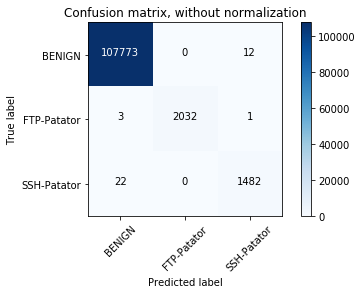

In [56]:
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()